自分用メモ  
LightGBMの確率出力が対応していなかったので、xgboostで挙動確認

公式githubにあるnotebookがベース
https://github.com/slundberg/shap/blob/master/notebooks/tree_explainer/Census%20income%20classification%20with%20XGBoost.ipynb

In [1]:
import xgboost
import shap
import numpy as np
import matplotlib.pylab as plt
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sns


# print the JS visualization code to the notebook
shap.initjs()

/Users/masato.ninohira/.pyenv/versions/3.5.6/lib/python3.5/site-packages/xgboost/__init__.py:28: FutureWarning: Python 3.5 support is deprecated; XGBoost will require Python 3.6+ in the near future. Consider upgrading to Python 3.6+.
  FutureWarning)


# データ読み込み

Adult Data Set https://archive.ics.uci.edu/ml/datasets/adult  
incomeが50k超えたらTrue

Note: 文字列で学習させたモデルを入れるとバグる関数が多発するので、一回数字に置換した後の学習を行うことを推奨

Note: xgboostにはcategorical featureへの対応がない、、、

In [2]:
# 文字列を含む
X, y = shap.datasets.adult(display=True)

# 文字列を置換済
X_num, _  = shap.datasets.adult()

# create a train/test split
X_train_num, X_test_num, y_train, y_test = train_test_split(X_num, y, test_size=0.2, random_state=7)
X_train, X_test, _, _ = train_test_split(X, y, test_size=0.2, random_state=7)

d_train_num = xgboost.DMatrix(X_train_num, label=y_train)
d_test_num = xgboost.DMatrix(X_test_num, label=y_test)

print(X_train_num.shape, X_test_num.shape)
X_train_num.head()

(26048, 12) (6513, 12)


,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
12011,51.0,4,10.0,0,6,0,4,0,0.0,0.0,40.0,21
23599,51.0,1,14.0,6,12,1,4,1,0.0,0.0,50.0,8
23603,21.0,4,11.0,4,3,3,2,1,0.0,0.0,40.0,39
6163,25.0,4,10.0,4,12,3,4,1,0.0,0.0,24.0,39
14883,48.0,4,13.0,0,1,3,4,1,0.0,0.0,38.0,39


# 学習

2値分類

In [3]:
params = {
    "eta": 0.01,
    "objective": "binary:logistic",
    "subsample": 0.5,
    "base_score": np.mean(y_train),
    "eval_metric": "logloss"
}

model_clf_num = xgboost.train(params, d_train_num, 5000, evals = [(d_train_num, "train"), (d_test_num, "test")], verbose_eval=100, early_stopping_rounds=20)

[0]	train-logloss:0.54790	test-logloss:0.54663
Multiple eval metrics have been passed: 'test-logloss' will be used for early stopping.

Will train until test-logloss hasn't improved in 20 rounds.
[100]	train-logloss:0.36053	test-logloss:0.36373
[200]	train-logloss:0.31202	test-logloss:0.31793
[300]	train-logloss:0.29264	test-logloss:0.30061
[400]	train-logloss:0.28196	test-logloss:0.29207
[500]	train-logloss:0.27473	test-logloss:0.28678
[600]	train-logloss:0.26965	test-logloss:0.28381
[700]	train-logloss:0.26546	test-logloss:0.28181
[800]	train-logloss:0.26211	test-logloss:0.28064
[900]	train-logloss:0.25905	test-logloss:0.27992
[1000]	train-logloss:0.25616	test-logloss:0.27928
Stopping. Best iteration:
[999]	train-logloss:0.25620	test-logloss:0.27927



In [4]:
params = {
    "eta": 0.01,
    "objective": "reg:squarederror",
    "subsample": 0.5,
    "base_score": np.mean(y_train),
    "eval_metric": "rmse"
}

model_reg_num = xgboost.train(params, d_train_num, 5000, evals = [(d_train_num, "train"), (d_test_num, "test")], verbose_eval=100, early_stopping_rounds=20)

[0]	train-rmse:0.42585	test-rmse:0.42512
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 20 rounds.
[100]	train-rmse:0.32961	test-rmse:0.33163
[200]	train-rmse:0.30720	test-rmse:0.31137
[300]	train-rmse:0.29892	test-rmse:0.30460
[400]	train-rmse:0.29411	test-rmse:0.30162
[500]	train-rmse:0.29092	test-rmse:0.30015
[600]	train-rmse:0.28853	test-rmse:0.29936
[700]	train-rmse:0.28639	test-rmse:0.29890
[800]	train-rmse:0.28437	test-rmse:0.29857
[900]	train-rmse:0.28247	test-rmse:0.29845
Stopping. Best iteration:
[885]	train-rmse:0.28275	test-rmse:0.29842



# 普通のimportance

In [5]:
def save_importances(importances_: pd.DataFrame):
    mean = importances.groupby('feature').mean().reset_index()
    plt.figure(figsize=(4, 4))
    sns.barplot(
        x='importance',
        y='feature',
        data=importances_.sort_values('importance', ascending=False)[:300])
    plt.tight_layout()
    plt.show()

In [6]:
def get_xgb_imp(xgb):
    imp_vals = xgb.get_fscore()
    feats_imp = pd.DataFrame(imp_vals,index=np.arange(2)).T
    feats_imp.iloc[:,0]= feats_imp.index    
    feats_imp.columns=['feature','importance']
    feats_imp.sort_values('importance',inplace=True,ascending=False)
    feats_imp.reset_index(drop=True,inplace=True)
    return feats_imp

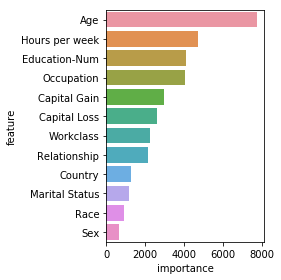

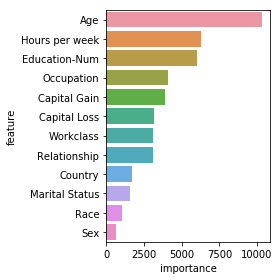

In [7]:
# 2値分類
importances = get_xgb_imp(model_clf_num)
#  回帰
importances_reg = get_xgb_imp(model_reg_num)

save_importances(importances)
save_importances(importances_reg)

# TreeExplainerの作成

https://shap.readthedocs.io/en/latest/#

In [8]:
explainer_clf_num_raw = shap.TreeExplainer(
    model_clf_num,
    model_output='raw',
)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


Note: xgboostだとやたら時間かかるため、headを使用  
https://github.com/slundberg/shap/blob/66b1f986c5f16dbc9de31d509f258d0cfef7a8c6/shap/explainers/tree.py#L115  

In [9]:
shap_values_clf_raw_train = explainer_clf_num_raw.shap_values(X_train_num.head(200))
shap_values_clf_raw_test = explainer_clf_num_raw.shap_values(X_test_num.head(200))

確率値

In [10]:
explainer_clf_num_pred = shap.TreeExplainer(
    model_clf_num,
    model_output='probability',
    data=X_train_num
)


Passing 26048 background samples may lead to slow runtimes. Consider using shap.sample(data, 100) to create a smaller background data set.


確率はもっと遅い。5データで1min
```
Passing 26048 background samples may lead to slow runtimes. Consider using shap.sample(data, 100) to create a smaller background data set.
  0%|                   | 18/26048 [03:31<5085:29]       
```

In [11]:
shap_values_clf_pred_train = explainer_clf_num_pred.shap_values(X_train_num.head(5))
shap_values_clf_pred_test = explainer_clf_num_pred.shap_values(X_test_num.head(5))

 80%|================    | 4/5 [00:41<00:10]       

回帰

In [12]:
# 回帰(数字置換後のデータ)
explainer_reg_num = shap.TreeExplainer(model_reg_num)

回帰もそれなりに時間がかかる。100データで2s

In [13]:
shap_values_reg_num_train = explainer_reg_num.shap_values(X_train_num.head(100))
shap_values_reg_num_test = explainer_reg_num.shap_values(X_test_num.head(100))

# force plot

個々の予測値への各変数の貢献度を可視化  
https://github.com/slundberg/shap/blob/master/shap/plots/force.py

分類

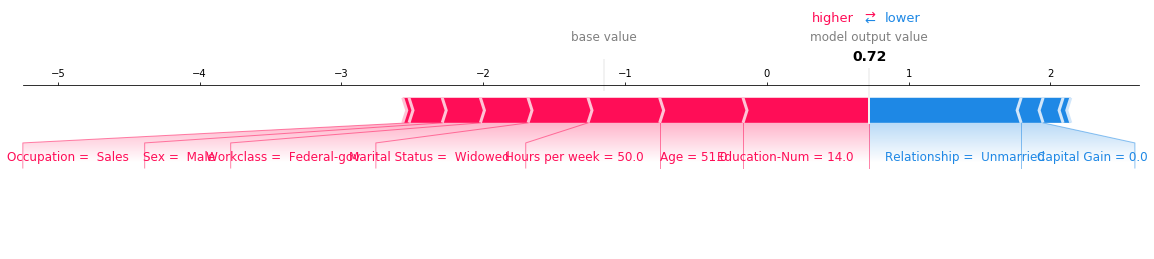

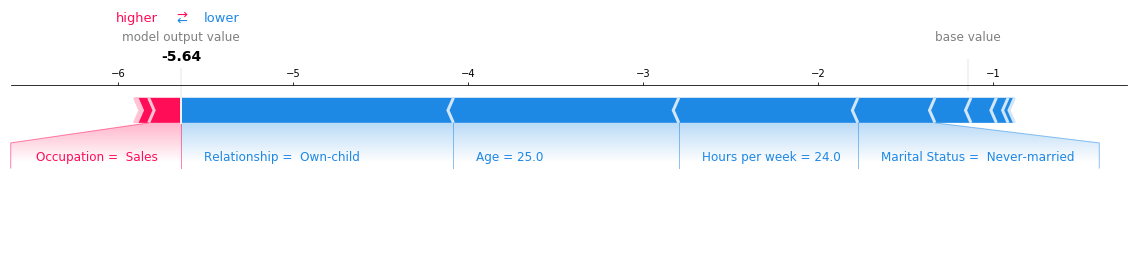

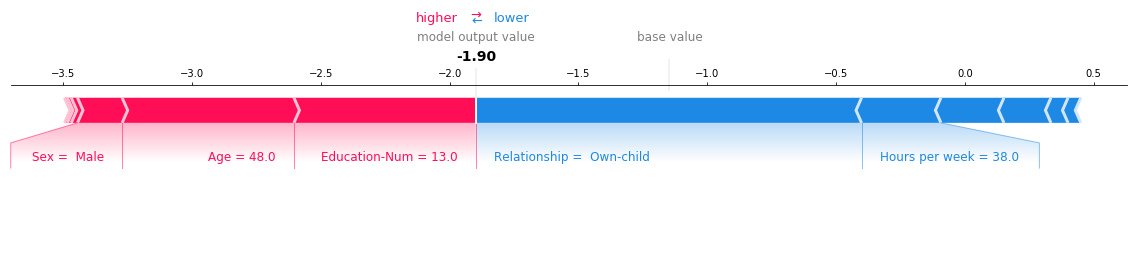

In [15]:
# raw
for i in [1, 3, 4]:
    shap.force_plot(
        base_value=explainer_clf_num_raw.expected_value,  # ベースライン
        shap_values=shap_values_clf_raw_train[i, :],  # 対象データのshap value(i番目のデータを求める例)
        features=X_train.iloc[i, :],  # ここでこれを与えないと、特徴量の値が表示されない
        matplotlib=True,  # 　default Javascript output
        show=False).savefig('xg_force_plot_clf_{}.png'.format(i), dpi=250, bbox_inches='tight')

上記値は確率ではないことに注意。  
sigmoid関数に通す前の値

In [16]:
import math
def sigmoid(a):
    s = 1 / (1 + e**-a)
    return s

e = math.e
print(model_clf_num.predict(xgboost.DMatrix(X_train_num.iloc[4:5,:])))
sigmoid(-1.90)

[0.1302882]


0.13010847436299786

確率  
i=4が0.13で上記と一致

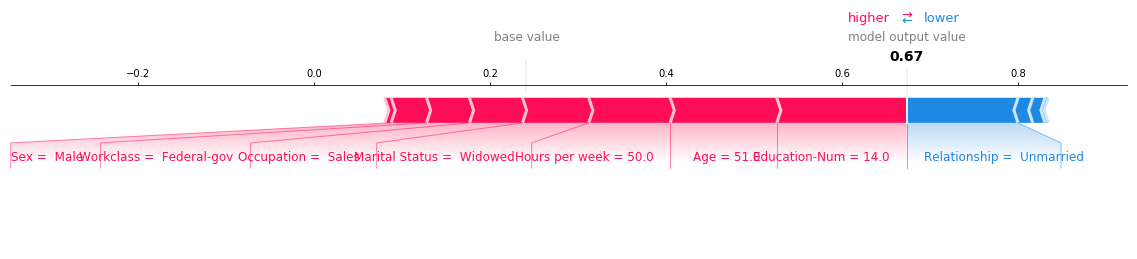

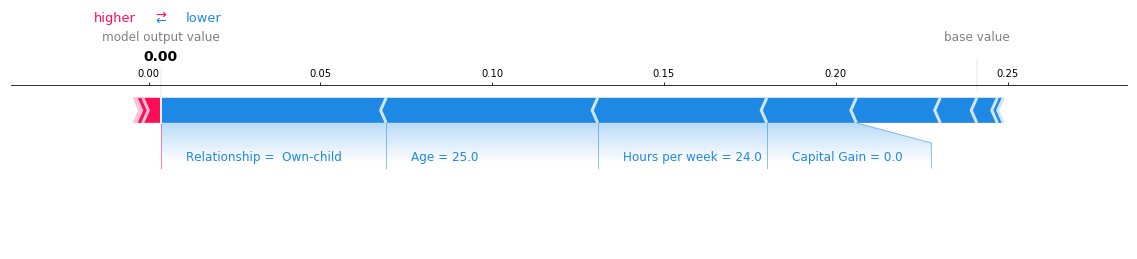

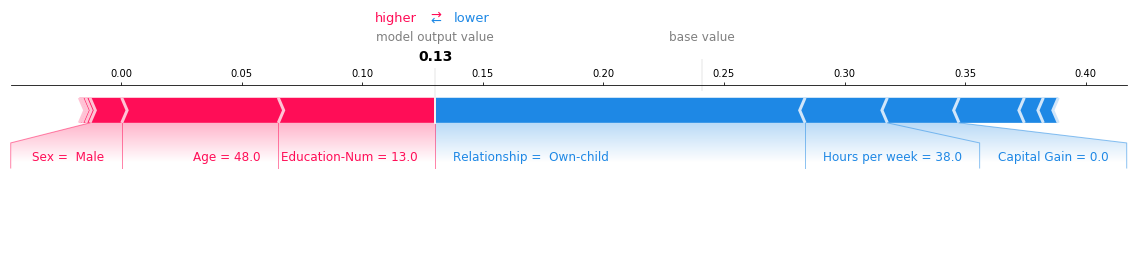

In [17]:
for i in [1, 3, 4]:
    shap.force_plot(
        # 2値分類なので、[1]にしていることに注意
        base_value=explainer_clf_num_pred.expected_value,  # ベースライン
        shap_values=shap_values_clf_pred_train[i, :],  # 対象データのshap value(i番目のデータを求める例)
        features=X_train.iloc[i, :],  # ここでこれを与えないと、特徴量の値が表示されない
        matplotlib=True,  # 　default Javascript output
        show=False).savefig('xg_force_plot_clf_pred_{}.png'.format(i), dpi=250, bbox_inches='tight')

回帰

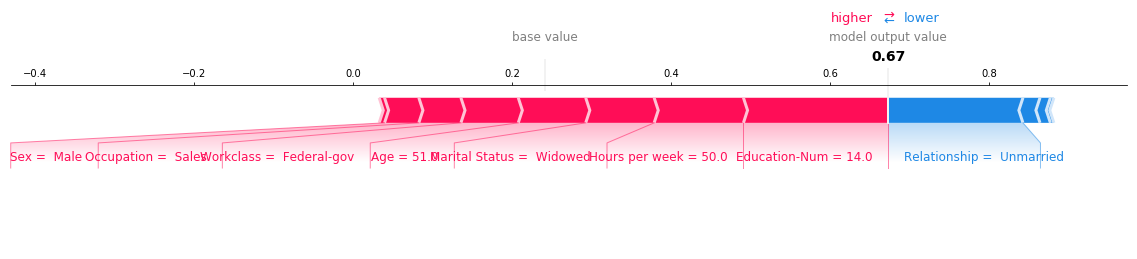

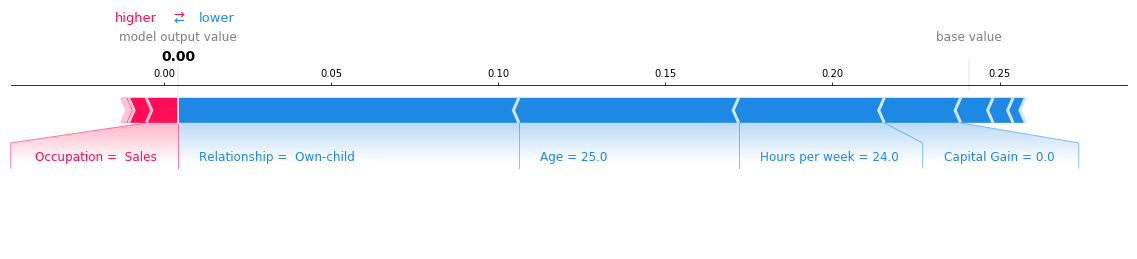

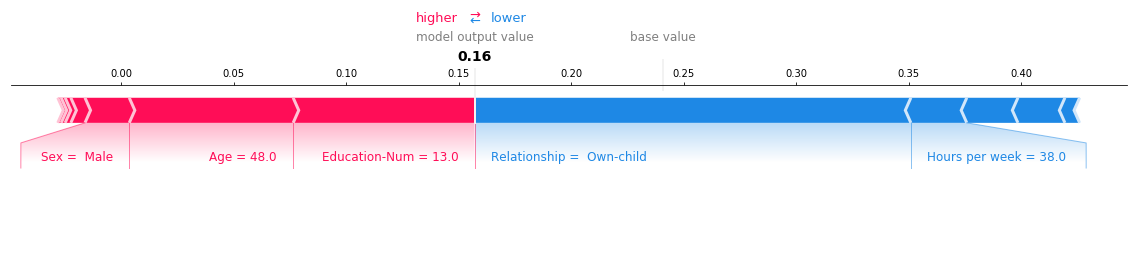

In [18]:
for i in [1, 3, 4]:
    shap.force_plot(
        explainer_reg_num.expected_value,  # ベースライン
        shap_values_reg_num_train[i, :],  # 対象データのshap value(i番目のデータを求める例)
        X_train.iloc[i, :],
        matplotlib=True,  # 　default Javascript output
        show=False).savefig('xg_force_plot_reg_{}.png'.format(i), dpi=250, bbox_inches='tight')

# waterfall_plot
個々の予測値への各変数の貢献度を可視化

pngで書き出すのが難しそう。  
- 関数の中ではplt.show()しているだけ
- 公式のexampleに使用例がない
- (figを取り出したい。。。)

https://github.com/slundberg/shap/blob/master/shap/plots/waterfall.py

分類

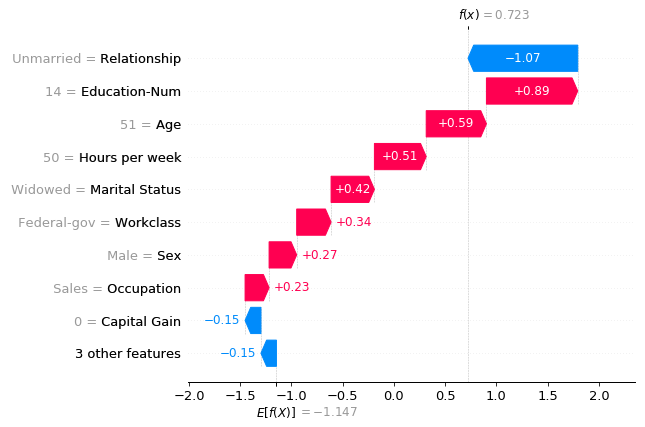

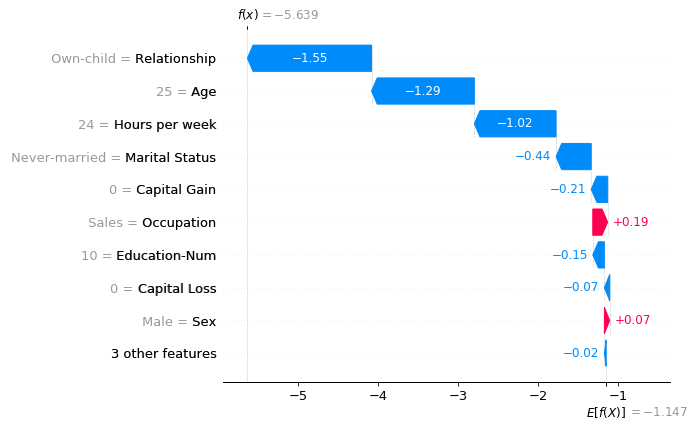

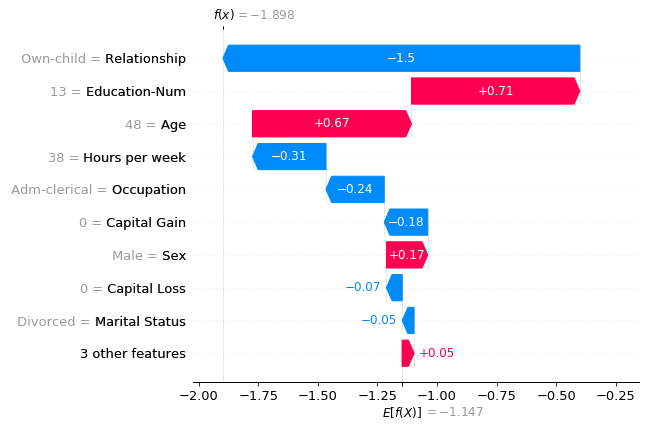

In [20]:
for i in [1, 3, 4]:
    shap.waterfall_plot(
        explainer_clf_num_raw.expected_value,
        shap_values_clf_raw_train[i, :],
        X_train.iloc[i, :])

確率も算出できた

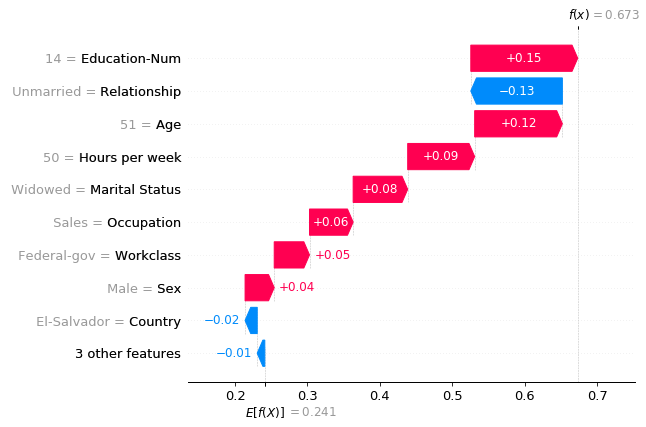

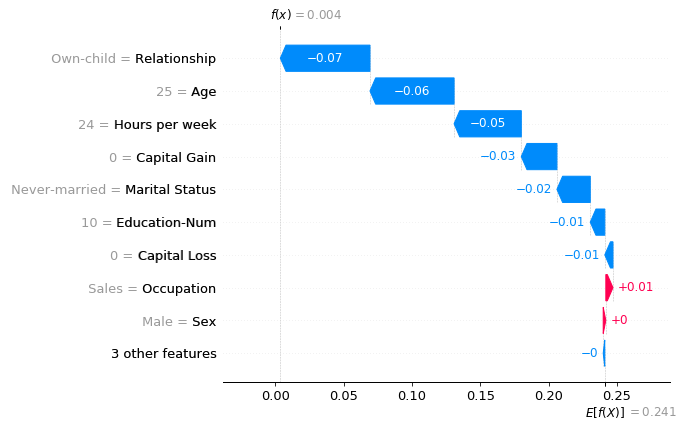

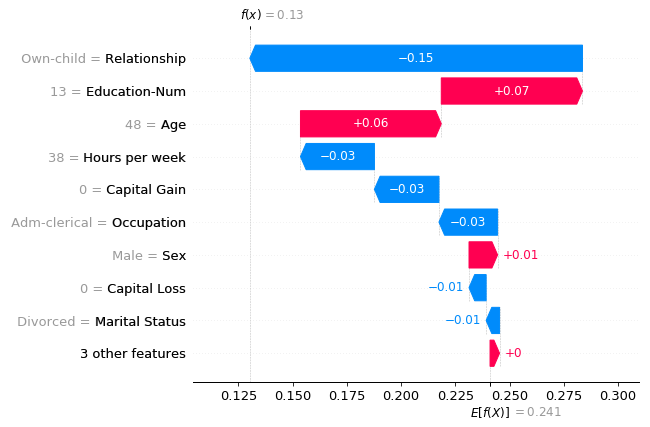

In [21]:
for i in [1, 3, 4]:
    shap.waterfall_plot(
        explainer_clf_num_pred.expected_value,
        shap_values_clf_pred_train[i, :],
        X_train.iloc[i, :])

回帰

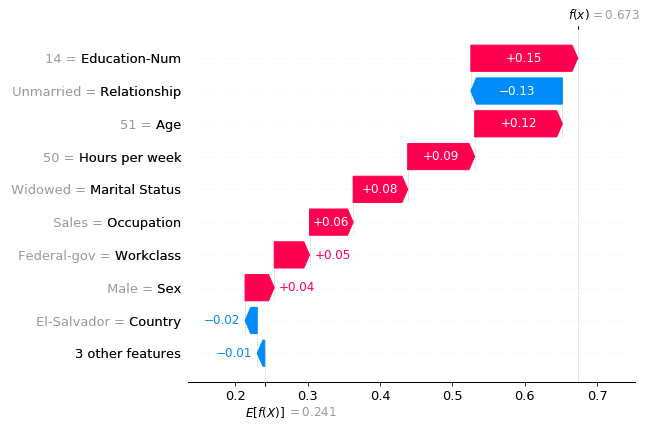

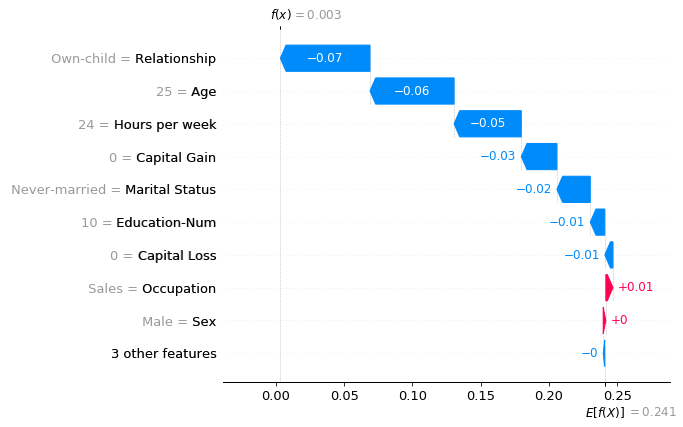

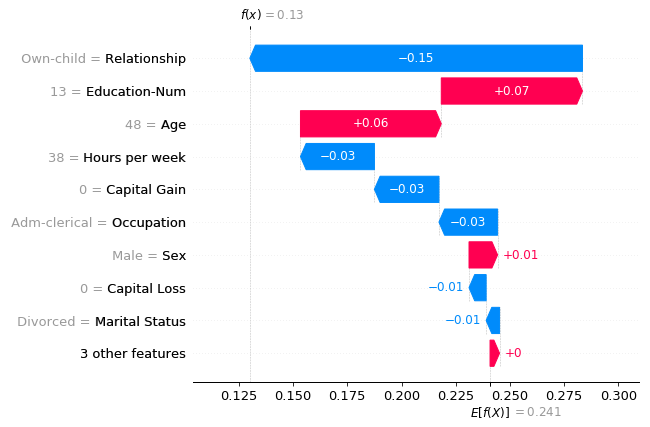

In [22]:
for i in [1, 3, 4]:
    shap.waterfall_plot(
        explainer_reg_num.expected_value,
        shap_values_clf_pred_train[i, :],
        X_train.iloc[i, :])